# Two use cases of FAIR maturity indicators in the life sciences

by [Serena Bonaretti](https://sbonaretti.github.io), Maastricht University

---
### Use cases

In this notebook, we consider 2 use-cases of data retrieval in the life sciences. For each case, we
- Execute data retrieval via API 
- Evaluate the FAIRness of the dataset

The 4 use-cases are:


<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 40%" /> 
<col style="width: 40%" /> 
</colgroup>
    
  <tr>
    <th></th>
    <th>Parkinson_AE</th>
    <th>NBIA_GEO</th>  
  </tr>
    
  <tr>
    <th>Research question</th>
    <th>What are the differentially expressed genes between normal subjects and subjects with Parkinson’s diseases in the brain frontal lobe?</th>
    <th>What is the function of mutation of WDR45 protein in the brain?</th>  
  </tr>
  
  <tr>
    <th>Dataset</th>
    <th><a href="https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-1194/?keywords=%22Parkinson%27s%20disease%22%20&organism=Homo%20sapiens&exptype%5B0%5D=&exptype%5B1%5D=%22array%20assay%22&array=&sortby=raw&sortorder=descending&page=1&pagesize=100">E-MTAB-1194</a></th>
    <th><a href="https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70433">GSE70433</a></th>  
  </tr>
  
  <tr>
    <th>Repository</th>
    <th><a href="https://www.ebi.ac.uk/arrayexpress/">ArrayExpress</a></th>
    <th><a href="https://www.ncbi.nlm.nih.gov/geo/">Gene Expression Omnibus</a></th>  
  </tr>

</table>




Information about repositories:
- **ArrayExpress**:
  - API: 
    - Documentation at https://www.ebi.ac.uk/arrayexpress/help/programmatic_access.html  
    - The API to query the repository is a rest API: https://www.ebi.ac.uk/arrayexpress/xml/v3/experiments
    - The API to get data is an FTP API: ftp://ftp.ebi.ac.uk/pub/databases/arrayexpress/data/  
  - Data structure:
    - Metadata are separated in two different layers, accessible via:
      - Generic metadata: accessible via rest API  
      - Specific metadata: accessible via FTP API  
      
      
- **Gene Expression Omnibus**: 
  - API: 
    - Documentation at https://www.ncbi.nlm.nih.gov/geo/info/geo_paccess.html
    - 5 possible queries are possible (https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4):  
      - eSearch: results of a search   
        (base URL: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi)  
      - eSummary: document summary   
        (base URL: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi)   
      - eFetch: formatted data records  
        (base URL: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi)
      - eLink: links to same or different repositories   
        (base URL: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi)
      - eInfo: statistics for a single repository, including lists of indexing fields and available link names  
        (base URL: https://eutils.ncbi.nlm.nih.gov/entrez/eutils/einfo.fcgi)


---

### Calculating FAIR metrics

[Prerequisites:](#prerequisites)  
- [Imports](#imports)  
- [Variables](#variables)  
- [Functions](#functions)  

[Retriving datasets:](#retrieval)  
- [Case 1: Parkinson_AE](#Parkinson_AE)  
- [Case 2: NBIA_GEO](#NBIA_GEO)  

[Retriving repositories in www.re3data.org](#Retriving_repositories_in_www.re3data.org)


[FAIR assessment:](#metrics) 
- [F1. (Meta)data are assigned a globally unique and persistent identifier](#F1) 
- [F2. Data are described with rich metadata](#F2) 
- [F3. Metadata clearly and explicitly include the identifier of the data it describes](#F3)  
- [F4. (Meta)data are registered or indexed in a searchable resource](#F4) 
- [A1. (Meta)data are retrievable by their identifier using a standardized communications protocol](#A1)    
- [A1.1 The protocol is open, free, and universally implementable](#A11)   
- [A1.2 The protocol allows for an authentication and authorization procedure, where necessary](#A12)   
- [A2. Metadata are accessible, even when the data are no longer available](#A2)  
- [I1. (Meta)data use a formal, accessible, shared, and broadly applicable language for knowledge representation](#I1) 
- [I2. Metadata use vocabularies that follow FAIR principles](#I2)  
- [I3. (Meta)data include qualified references to other (meta)data](#I3)   
- [R1.1. (Meta)data are released with a clear and accessible data usage license](#R11)  
- [R1.2. (Meta)data are associated with detailed provenance](#R12)  
- [R1.3. (Meta)data meet domain-relevant community standards](#R13)

[FAIR assessment visualization](#visualization)

[Dependencies](#dependencies)

[Supplementary information](#supplementary_information)

---

<a name="prerequisites"></a>
### Prerequisites

<a name="imports"></a>
#### Imports

In [1]:
# import python packages
import os
import pandas as pd
import requests
import time
import xml.etree.ElementTree as ET
from io import StringIO

In [2]:
# Import R for visualization using ggplot2 - comment if used in mybinder, uncomment if used locally
#os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources' # put here your own R directory 

In [2]:
%load_ext rpy2.ipython

<a name="variables"></a>
#### Variables

In [3]:
# re3Data API
re3data_repos    = "https://www.re3data.org/api/v1/repositories"
re3data_repo     = "https://www.re3data.org/api/v1/repository"
re3data_schema   = '{http://www.re3data.org/schema/2-2}' # in the metadata xml

In [4]:
# repository variables
repository_name  = []
repository_api   = []
dataset_download = []

# ArrayExpress
repository_name.append("ArrayExpress")
repository_api.append("https://www.ebi.ac.uk/arrayexpress/xml/v3/experiments")
dataset_download.append("https://www.ebi.ac.uk/arrayexpress/xml/v3/files/")

# GEO
repository_name.append("Gene Expression Omnibus")
repository_api.append("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?")
metadata_api       = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?"
repository_acronym = "gds" # gene dataset

In [5]:
# case names
case_names        = []
case_names.append("Parkinson_AE")
case_names.append("NBIA_GEO")

In [6]:
# search keywords
keywords = []

# ArrayExpress
kw = []
kw.append("parkinson's disease")
kw.append("transcription profiling by array") #['female', 'transcription profiling by array', 'normal', 'frontal lobe', 'male']
kw.append("homo sapiens")
kw.append("frontal lobe")
kw.append("male")
kw.append("female")
kw.append("normal")
kw.append("true")
keywords.append(kw)

# GEO
kw = []
kw.append("nbia")
kw.append("homo sapiens")
kw.append("expression profiling by array")
keywords.append(kw)

In [7]:
# output variables used for FAIR assessment

request_status        = []
metadata_xml          = [] 
metadata_list         = [] # list of lists. Dimension: n_of_cases x 1. 
                           # Inside each cell, list of dimension 2 x N. First row is tags, second row is text of the xml output containing metadata
re3data_repo_root     = []
re3data_metadata_list = [] # same structure as metadata_list
n_of_found_keywords   = []
dataset_title         = []

F1  = []
F2  = []
F3  = []
F4  = []
A1  = []
A11 = []
A12 = []
A2  = []
I1  = []
I2  = []
I3  = []
R1  = []
R11 = []
R12 = []
R13 = []

<a name="functions"></a>
#### Functions

In [8]:
def find_repo_in_re3_data (repository_name):
    """
    It retrieves metadata about the input repository in re3data.org
    """
    
    # contact the re3data
    re3data_r = requests.get(re3data_repos)
    
    # put output string in a structured xml tree
    re3data_root = ET.fromstring(re3data_r.text)

    # look for the wanted repository
    flag = 0
    for i in range (0, len(re3data_root)):
        if re3data_root[i][1].text == repository_name: # first index is a <repository> group, 
                                                       # second index is for the tags inside (<id>, <name>, <link>)
            flag = 1
            repository_index = i

    if flag == 1:   
        
        re3data_metadata_address = str(re3data_root[repository_index][2].attrib["href"])
        #print ("Index in list: " + str(repository_index))
        #print ("Tag          : " + str(re3data_root[repository_index][1].tag))
        #print ("Text         : " + str(re3data_root[repository_index][1].text))
        #print ("Tag          : " + str(re3data_root[repository_index][2].tag))
        #print ("Attribute    : " + str(re3data_root[repository_index][2].attrib)) # attributes do not have a closing tag

    else: 
        print ("Repository not found")
        
    return re3data_metadata_address

In [9]:
def pretty_print_xml (root): 
    """
    It prints xml with identations
    """
    
    count = 0
    for i in range (0, len(root)):

        if len(root[i]) == 0:
            print ("<"  + str(root[i].tag) + ">")
            print ("   " + str(root[i].text))
            count = count + 1
        else: 
            for j in range(0, len(root[i])):
                if len(root[i][j]) == 0:
                    print ("<"  + str(root[i][j].tag) + ">")
                    print ("   " + str(root[i][j].text))
                    print ("<"  + str(root[i][j].tag + ">"))
                    count = count + 1
                else: 
                    for k in range (0, len(root[i][j])):
                        print ("  <"  + str(root[i][j][k].tag + ">"))
                        print ("      " + str(root[i][j][k].text))
                        count = count + 1
    return count

In [10]:
def xml_to_list(root): 
    
    """
    It creates a list with dimensions 2xN, where N is the number of tags in the xml file. The first row contains tags and the second row text
    It extracts items that are nested and puts them at the same level as the parent tags
    """
    
    xml_list_tag = []
    xml_list_text = []
    
    for i in range (0, len(root)):

        if len(root[i]) == 0:
            tag  = str(root[i].tag)
            text = str(root[i].text)
            xml_list_tag.append(tag.lower()) # all strings in lower case for easier string finding
            xml_list_text.append(text.lower())
        else: 
            for j in range(0, len(root[i])):
                if len(root[i][j]) == 0:
                    tag  = str(root[i][j].tag)
                    text = str(root[i][j].text)
                    xml_list_tag.append(tag.lower()) 
                    xml_list_text.append(text.lower())
                else: 
                    for k in range (0, len(root[i][j])):
                        tag  = str(root[i][j][k].tag)
                        text = str(root[i][j][k].text)
                        xml_list_tag.append(tag.lower()) 
                        xml_list_text.append(text.lower())
    
    xml_list = [ xml_list_tag, xml_list_text ]
    
    return xml_list

In [11]:
def find_list_in_list(long_list, short_list):
    """
    For each items of short_list, it looks in the long_list
    It uses a "for" loop because it has to look also for parts of string
    Inputs: 
     long_list: long list of strings
     short_list: short list of strings
    Outputs:
     found: elements of short_list found in long_list
     index: index of found elements in long_list   
    """
    
    found = []
    index = []
    for i in range(0, len(long_list)):
        for j in range(0, len(short_list)):
            if long_list[i].find(short_list[j]) != -1 :
                found.append(short_list[j])
                index.append(i)
    return found, index

---

<a name="retrieval"></a>
### Retriving datasets 

<a name="Parkinson_AE"></a>
#### Case 1: Parkinson_AE

In [12]:
case_id = 0

In [13]:
# getting dataset
start_time = time.time()
r_repo = requests.get(repository_api[case_id],
                  params={"keywords"      :  keywords[case_id][0], # "Parkinson's disease"
                          "experimenttype":  keywords[case_id][1], # "transcription profiling by array"
                          "organism"      :  keywords[case_id][2], # "Homo sapiens" 
                          "sa"            : [keywords[case_id][0], keywords[case_id][3], keywords[case_id][4], keywords[case_id][5]],  # "Parkinson's disease", "frontal lobe", "male", "female"
                          "diseasestate"  : [keywords[case_id][0], keywords[case_id][6]], # "Parkinson's disease",  "normal"
                          "raw"           :  keywords[case_id][7]})

print ("-> The time to retrieve the dataset was %.2f seconds" % ((time.time() - start_time)))

# add request status
request_status.append(r_repo.status_code)

# convert answer from string to xml_tree
root = ET.fromstring(r_repo.text)
print("number of datasets found: " + str (len(root)))

-> The time to retrieve the dataset was 34.90 seconds
number of datasets found: 2


Because the query via API reports 2 results, we have to investigate a second layer of metadata that is not provided in the API but is part of the downloadable package.  
We use this metadata only to to select the dataset to use, not to assess FAIRness

In [14]:
# look for experiment_id 
experiment_id = []

for accession in root.iter('accession'):
    if len(accession.text) == 11:
        experiment_id.append(accession.text)
print (experiment_id)

['E-MTAB-1194', 'E-GEOD-7307']


In [15]:
# get metadata of dataset 1
d1_url = dataset_download[0] + experiment_id[0] + "/"
d1_r = requests.get(d1_url)
# pass output to ET
d1_root = ET.fromstring(d1_r.text)

# look for urls of file names to download
for url in d1_root.iter('url'):
    if "sdrf.txt" in str(url.text):
        d1_sdrf_name = url.text
    
# get file
df1_r = requests.get(d1_sdrf_name)

# convert string tabular text to pandas dataframe
full_string = StringIO(df1_r.text)
df1 = pd.read_csv(full_string, sep="\t")
# df1

# check how many columns with "Parkinson's desease" correspond to "frontal lobe"
b = df1[ ( df1["Characteristics[DiseaseState]"] == "Parkinson's disease" ) & (df1["Characteristics[OrganismPart]"] == "frontal lobe")]
df1_n_of_corresponding_rows = b.shape[0]
#b

In [16]:
# get metadata of the dataset 2
d2_url = dataset_download[0] + experiment_id[1] + "/"
d2_r = requests.get(d2_url)
# pass output to ET
d2_root = ET.fromstring(d2_r.text)

# look for urls of file names to download
for url in d2_root.iter('url'):
    if "sdrf.txt" in str(url.text):
        d2_sdrf_name = url.text
    
# get file
df2_r = requests.get(d2_sdrf_name)

# convert string tabular text to pandas dataframe
full_string = StringIO(df2_r.text)
df2 = pd.read_csv(full_string, sep="\t")

# show all columns
n_of_columns = df2.shape[1]
pd.set_option("display.max_columns",n_of_columns)
pd.set_option("display.max_rows",10)
#df2

# check if columns with "Parkinson's desease" correspond to "frontal lobe"
b = df2[ ( df2["Characteristics [DiseaseState]"] == "Parkinson's disease" ) & (df2["Characteristics [OrganismPart]"] == "frontal lobe")]
df2_n_of_corresponding_rows = b.shape[0]
# b

In [17]:
# select the dataset 
if df1_n_of_corresponding_rows > df2_n_of_corresponding_rows:
    # metadata in xml
    #metadata.append(root[0])
    # metadata in list
    metadata_xml.append(root[0])
    metadata_list.append(xml_to_list(root[0]))
    print ("Using dataset: " + str(experiment_id[0]))
else: 
    # metadata in xml
    #metadata.append(root[1])
    # metadata in list
    metadata_xml.append(root[1])
    metadata_list.append(xml_to_list(root[1]))
    print ("Using dataset: " + str(experiment_id[0]))

Using dataset: E-MTAB-1194


In [18]:
# print metadata
# pretty_print_xml (metadata[case_id])

<a name="NBIA_GEO"></a>
#### Case 2: NBIA_GEO

In [19]:
case_id = 1

In [20]:
# getting dataset
start_time = time.time()
query_string = keywords[case_id][0] +  " AND " + keywords[case_id][1] + " AND " + keywords[case_id][2]
r_repo = requests.get(repository_api[case_id],
                  params={"db"   : repository_acronym,
                          "term" : query_string})

print ("-> The time to retrieve the dataset was %.2f seconds" % ((time.time() - start_time)))

# add request status
request_status.append(r_repo.status_code)

# convert answer from string to xml_tree
root = ET.fromstring(r_repo.text)

#pretty_print_xml (root)

-> The time to retrieve the dataset was 0.77 seconds


In [21]:
# get identifier
for field in root.iter('Id'):
    id = field.text

# get metadata
r_meta = requests.get(metadata_api,
                  params={"db" : repository_acronym,
                          "id" : id})
root_meta = ET.fromstring(r_meta.text)

In [22]:
# metadata in xml
metadata_xml.append(root_meta[0])
# metadata in list
metadata_list.append(xml_to_list(root_meta[0]))

<a name="Retriving_repositories_in_www.re3data.org"></a>
### Retriving repositories in www.re3data.org

In [23]:
start_time = time.time()

for case_id in range (0, len(repository_name)):  
    
    print ("- " + repository_name[case_id])
        
    # extract repository metadata
    re3data_metadata_address = find_repo_in_re3_data (repository_name[case_id])

    # extract repository number 
    repository_number = re3data_metadata_address[re3data_metadata_address.rfind('/') : len(re3data_metadata_address)]

    # metadata_url
    metadata_url      = re3data_repo + str(repository_number)

    # access the repository metadata 
    re3data_repo_r = requests.get(metadata_url)

    # put the output string in a structured xml tree
    re3data_repo_root.append(ET.fromstring(re3data_repo_r.text)) # saved if needed for pretty_print_xml visualization
    
    # put the output string in a list of lists
    re3data_metadata_list.append(xml_to_list(re3data_repo_root[case_id]))
       
print ("-> The time to retrieve the information was %.2f seconds" % ((time.time() - start_time)))

- ArrayExpress
- Gene Expression Omnibus
-> The time to retrieve the information was 9.40 seconds


---

<a name="metrics"></a>
### FAIR assessment

---

<a name="F1"></a>
#### F1. (Meta)data are assigned a globally unique and persistent identifier
We used www.re3data.org to check whether the repository provides a globally unique and persistent identifier.  
Because it is not possible to retrieve this information via API, we manually checked the "doi" icon at the top-right of each repository page. 
We manually assigned: 
- `1` when the hovered icon stated: *The research data repository uses DOI to make its provided data persistent, unique and citable* 
- `0` when the hovered icon stated: *The research data repository does not use a persistent identifier system*  

In [24]:
# Parkinson_AE
F1.append(0) # information retrieved at: https://www.re3data.org/repository/r3d100010222

# NBIA_GEO
F1.append(0) # information retrieved at: https://www.re3data.org/repository/r3d100010283

# Print out F1 values
print ("--> F1 are: " + str(F1) )

--> F1 are: [0, 0]


---

<a name="F2"></a>
#### F2. Data are described with rich metadata 

Metadata contain the keywords used in the query

In [25]:
for case_id in range (0, len(repository_name)):
    
    # in ArrayExpress the keyworkd "true" used for `request` becomes `rawdata` in metafile
    if case_id == 0:
        keywords[case_id][-1] = "rawdata"
    
    # look for keywords in metadata text 
    output, index = find_list_in_list(metadata_list[case_id][1], keywords[case_id]) # metadata_list[0] is tags, metadata_list[1] is text
    
    # get unique found keywords (one keyword can be present more than once
    found = list(set(output) ) 
    
    # print out found keywords
    print ("- " + repository_name[case_id])
    print ("    " + str(found))
    
    # n of keywords found - used in R1
    n_of_found_keywords.append(len(found))

    # assign F2
    if len(found) == 0: # none of the search keywords are in the metafile data
        F2.append(0)
        print ("    No keyword found")
    else:
        F2.append(len(found)/len(keywords[case_id]))
        print ("    Found " + str(len(found)) + " keywords")

# print F2
print ("--> F2: " + str(F2))

- ArrayExpress
    ['frontal lobe', "parkinson's disease", 'transcription profiling by array', 'rawdata', 'homo sapiens', 'female', 'male', 'normal']
    Found 8 keywords
- Gene Expression Omnibus
    ['expression profiling by array', 'nbia', 'homo sapiens']
    Found 3 keywords
--> F2: [1.0, 1.0]


---

<a name="F3"></a>
#### F3. Metadata clearly and explicitly include the identifier of the data it describes  

In [26]:
for case_id in range (0, len(repository_name)):
    
    # look for keywords in metadata tag
    output, index = find_list_in_list(metadata_list[case_id][0], ["id"]) # metadata_list[0] is tags, metadata_list[1] is text
    print ("- " + repository_name[case_id])
    
    # both in Parkinson_AE and NBIA_GEO metadata there are various "id" tags. The one that refers to the datset is the first (=> index[0])
    print ("id: " + metadata_list[case_id][1][index[0]])
    
    F3.append(1)
          
print ("--> F3: " + str(F3) )

- ArrayExpress
id: 219251
- Gene Expression Omnibus
id: 200070433
--> F3: [1, 1]


---

<a name="F4"></a>
#### F4. (Meta)data are registered or indexed in a searchable resource

Manual search for the dataset title in [Google Dataset Search](https://toolbox.google.com/datasetsearch)

In [27]:
# get dataset titles

# Parkinson_AE
case_id = 0
output, index = find_list_in_list(metadata_list[case_id][0], ["name"]) # metadata_list[0] is tags, metadata_list[1] is text
dataset_title.append(metadata_list[case_id][1][index[0]]) # there are 4 tags "name". the dataset title is the first (=> index[0])
        
# NBIA_GEO
case_id = 1
dataset_title.append(str(metadata_list[case_id][1][3])) # the majority of all the tags are "item"

# print out
print ("Dataset titles: ")
for i in range(0, len(dataset_title)): 
    print (case_names[i] + ": "+ dataset_title[i])
    
# manually find dataset in Google Dataset Search
F4.append(1)    # Parkinson_AE: https://toolbox.google.com/datasetsearch/search?query=Transcription%20profiling%20by%20array%20of%20human%20frontal%20cortex%20(area%208)%20from%20Parkinson%20disease%20cases%20and%20controls&docid=eYq%2F%2Bx3Qkyz18DYbAAAAAA%3D%3D
F4.append(0)    # NBIA_GEO: https://toolbox.google.com/datasetsearch/search?query=Gene%20expression%20in%20human%20or%20mouse%20brain%20with%20iron%20loading

print ("--> F4: " + str(F4) )

Dataset titles: 
Parkinson_AE: transcription profiling by array of human frontal cortex (area 8) from parkinson disease cases and controls
NBIA_GEO: gene expression in human or mouse brain with iron loading
--> F4: [1, 0]


---

<a name="A1"></a>
#### A1. Metadata are retrievable by their identifier using a standardized communications protocol   

In this implementation we retrieve information only via HTTP, so we check whether the request response is 200 (= site responding)

In [28]:
# for all use cases
for i in range(0, len(request_status)):
    if request_status[i] == 200:
        A1.append(1) 
    else:
        A1.append(0)  

print ("--> A1: " + str(A1)) 

--> A1: [1, 1]


<a name="A11"></a>
#### A1.1 The protocol is open, free, and universally implementable

In this implementation we retrieve information only via HTTP, so if A1=1 then A11=1

In [29]:
# for all use cases
for case_id in range (0, len(A1)):
    if A1[case_id] == 1:
        A11.append(1)
    else:
        A11.append(None)
        
print ("--> A11: " + str(A11)) 

--> A11: [1, 1]


<a name="A12"></a>
#### A1.2 The protocol allows for an authentication and authorization procedure, where necessary
In this implementation we retrieve information only via HTTP, so if A1=1 then A11=1

In [30]:
# for all use cases
for case_id in range (0, len(A1)):
    if A1[case_id] == 1:
        A12.append(1)
    else:
        A12.append(None)
        
print ("--> A12: " + str(A12)) 

--> A12: [1, 1]


<a name="A2"></a>
#### A2. Metadata are accessible, even when the data are no longer available  

We look for `data availability policy` in the repository metadata extracted from www.re3data.org

In [31]:
start_time = time.time()

for case_id in range (0, len(repository_name)):  
    
    print ("- " + repository_name[case_id])
            
    # find the policy
    output, index = find_list_in_list(re3data_metadata_list[case_id][1], ["data availability  policy"])
    if len(index) != 0: 
        print ("    Policy at: " + re3data_metadata_list[case_id][1][index[0]+1]) # 
        A2.append(1)
    else:
        print ("    Policy not found")
        A2.append(0)
        
print ("-> The time to retrieve the information was %.2f seconds" % ((time.time() - start_time)))

print ("--> A2: " + str(A2)) 

- ArrayExpress
    Policy at: https://www.ebi.ac.uk/ena/about/data-availability-policy
- Gene Expression Omnibus
    Policy not found
-> The time to retrieve the information was 0.00 seconds
--> A2: [1, 0]


---

<a name="I1"></a>
#### I1. Metadata use a formal, accessible, shared, and broadly applicable language for knowledge representation 

We manually check the metadata format

In [32]:
I1.append(1) # Parkinson_AE  : XML (https://www.ebi.ac.uk/arrayexpress/help/programmatic_access.html#Format_XML_results)
I1.append(1) # NBIA_GEO      : XML

print ("--> I1: " + str(I1) )    

--> I1: [1, 1]


---

<a name="I2"></a>
#### I2. Metadata use vocabularies that follow FAIR principles
We did not assess this principle, so we assign `None` to the metric

In [33]:
# Parkinson_AE
I2.append(-0.001) 
# NBIA_GEO
I2.append(-0.001) 

print ("--> I2: " + str(I2))

--> I2: [-0.001, -0.001]


---

<a name="I3"></a>
#### I3. (Meta)data include qualified references to other (meta)data  
Manually checked if there are references in metadata

In [34]:
# Parkinson_AE
I3.append(0) 
# NBIA_GEO
I3.append(0) 

print ("--> I3: " + str(I3))

--> I3: [0, 0]


---

<a name="R1"></a>
#### R1 (meta)data are richly described with a plurality of accurate and relevant attributes 
Check if there are more metadata than the keywords used in F2

In [35]:
for case_id in range (0, len(repository_name)):
    
    total_number_of_metadata = len(metadata_list[case_id][0])
    remaining_metadata = total_number_of_metadata - n_of_found_keywords[case_id]
    
    if remaining_metadata > 0:
        R1.append(1)
        print ("Number of metadata excluding keywords: " + str(remaining_metadata))
    else: 
        R1.append(0)

print ("--> R1: " + str(R1))

Number of metadata excluding keywords: 56
Number of metadata excluding keywords: 58
--> R1: [1, 1]


---

<a name="R11"></a>
#### R1.1. Metadata are released with a clear and accessible data usage license 

We look for `datalicensename` and `datalicenseurl` in the repository metadata extracted from www.re3data.org

In [36]:
for case_id in range (0, len(repository_name)):

    print ("- " + repository_name[case_id])
   
    # find the policy and its url
    output_name, index_name = find_list_in_list(re3data_metadata_list[case_id][0], ["datalicensename"])
    output_url , index_url  = find_list_in_list(re3data_metadata_list[case_id][0], ["datalicenseurl"])
    for i in range(0, len(index_name)): 
        print ("    License name: " + re3data_metadata_list[case_id][1][index_name[i]])
        print ("    License url : " + re3data_metadata_list[case_id][1][index_url[i]])
    
    if output_url != []:
        R11.append(1) 
    else: 
        R11.append(0)

print ("--> R11: " + str(R11)) 



- ArrayExpress
    License name: other
    License url : https://www.ebi.ac.uk/arrayexpress/help/data_availability.html
- Gene Expression Omnibus
    License name: copyrights
    License url : http://www.ncbi.nlm.nih.gov/geo/info/disclaimer.html
--> R11: [1, 1]


---

<a name="R12"></a>
#### R1.2. (Meta)data are associated with detailed provenance  

We check whether the dataset metadata contain `authors`, `email` of at least one author, and `title` of related publication 

In [37]:
for case_id in range (0, len(repository_name)):
    
    print ("- " + repository_name[case_id])
    
    # counter 
    provenance = 0
    
    # author names
    output, index = find_list_in_list(metadata_list[case_id][0], ["authors"]) # metadata_list[0] is tags, metadata_list[1] is text
    if index != []:
        print ("    authors: " + metadata_list[case_id][1][index[0]])
        provenance = provenance + 1
    
    # author email
    output, index = find_list_in_list(metadata_list[case_id][0], ["email"]) # metadata_list[0] is tags, metadata_list[1] is text
    if len(index) != 0:
        print ("    email: " + metadata_list[case_id][1][index[0]])
        provenance = provenance + 1
    
    # publication title
    output, index = find_list_in_list(metadata_list[case_id][0], ["title"]) # metadata_list[0] is tags, metadata_list[1] is text
    if index != []:
        print ("    title: " + metadata_list[case_id][1][index[0]])
        provenance = provenance + 1
    
    # calculate R12
    if provenance == 3:
        R12.append(1)
    elif provenance == 0: 
        R12.append(0)
    else:
        R12.append(0.5) 

print ("--> R12: " + str(R12))

- ArrayExpress
    authors: garcia-esparcia p, schlüter a, carmona m, moreno j, ansoleaga b, torrejón-escribano b, gustincich s, pujol a, ferrer i.
    email: aschluter@idibell.org
    title: functional genomics reveals dysregulation of cortical olfactory receptors in parkinson disease: novel putative chemoreceptors in the human brain.
- Gene Expression Omnibus
--> R12: [1, 0]


---

<a name="R13"></a>
#### R1.3. (Meta)data meet domain-relevant community standards
We do not evaluate this metric because of current lack of community standards. We assign `None` to the metric

In [38]:
# Parkinson_AE
R13.append(-0.001) 
# NBIA_GEO
R13.append(-0.001) 

print ("--> R13: " + str(R13))

--> R13: [-0.001, -0.001]


--- 

<a name="visualization"></a>
### FAIR assessment visualization

In [39]:
import numpy as np
# create empty dataframe 
df = pd.DataFrame()

data = {
        "F1"    : F1,
        "F2"    : F2,
        "F3"    : F3,
        "F4"    : F4,
        "A1"    : A1,
        "A11"   : A11,
        "A12"   : A12, 
        "A2"    : A2,
        "I1"    : I1,
        "I2"    : I2,
        "I3"    : I3,
        "R1"    : R1,
        "R11"   : R11,   
        "R12"   : R12,     
        "R13"   : R13,


       }

# create dataframe
df = pd.DataFrame (data)

# transpose for plotting (to be retranspose in plotting)
df = df.T

# change column names
df.columns = ['Parkinsons_AE', 'NBIA_GEO']



# add criteria for plotting
principles         = ["F",      "F",         "F",         "F",      "A",         "A",         "A",         "A",         "I",       "I",             "I",      "R",         "R",         "R"          ,"R"]
metric_names       = ["F1",     "F2",        "F3",        "F4",     "A1",        "A11",       "A12",       "A2",        "I1",      "I2",            "I3",     "R1",        "R11",       "R12"        ,"R13" ]
retrieval_type     = ["manual", "automatic", "automatic", "manual", "automatic", "automatic", "automatic", "automatic", "manual",  "N/A",  "manual", "automatic", "automatic", "automatic" , "N/A" ]
df["principles"]     = principles
df["metric_names"]   = metric_names
df["retrieval_type"] = retrieval_type

# display
pd.set_option("display.max_rows",df.shape[0])
df

,Parkinsons_AE,NBIA_GEO,principles,metric_names,retrieval_type
F1,0.000,0.000,F,F1,manual
F2,1.000,1.000,F,F2,automatic
F3,1.000,1.000,F,F3,automatic
F4,1.000,0.000,F,F4,manual
A1,1.000,1.000,A,A1,automatic
A11,1.000,1.000,A,A11,automatic
A12,1.000,1.000,A,A12,automatic
A2,1.000,0.000,A,A2,automatic
I1,1.000,1.000,I,I1,manual
I2,-0.001,-0.001,I,I2,N/A


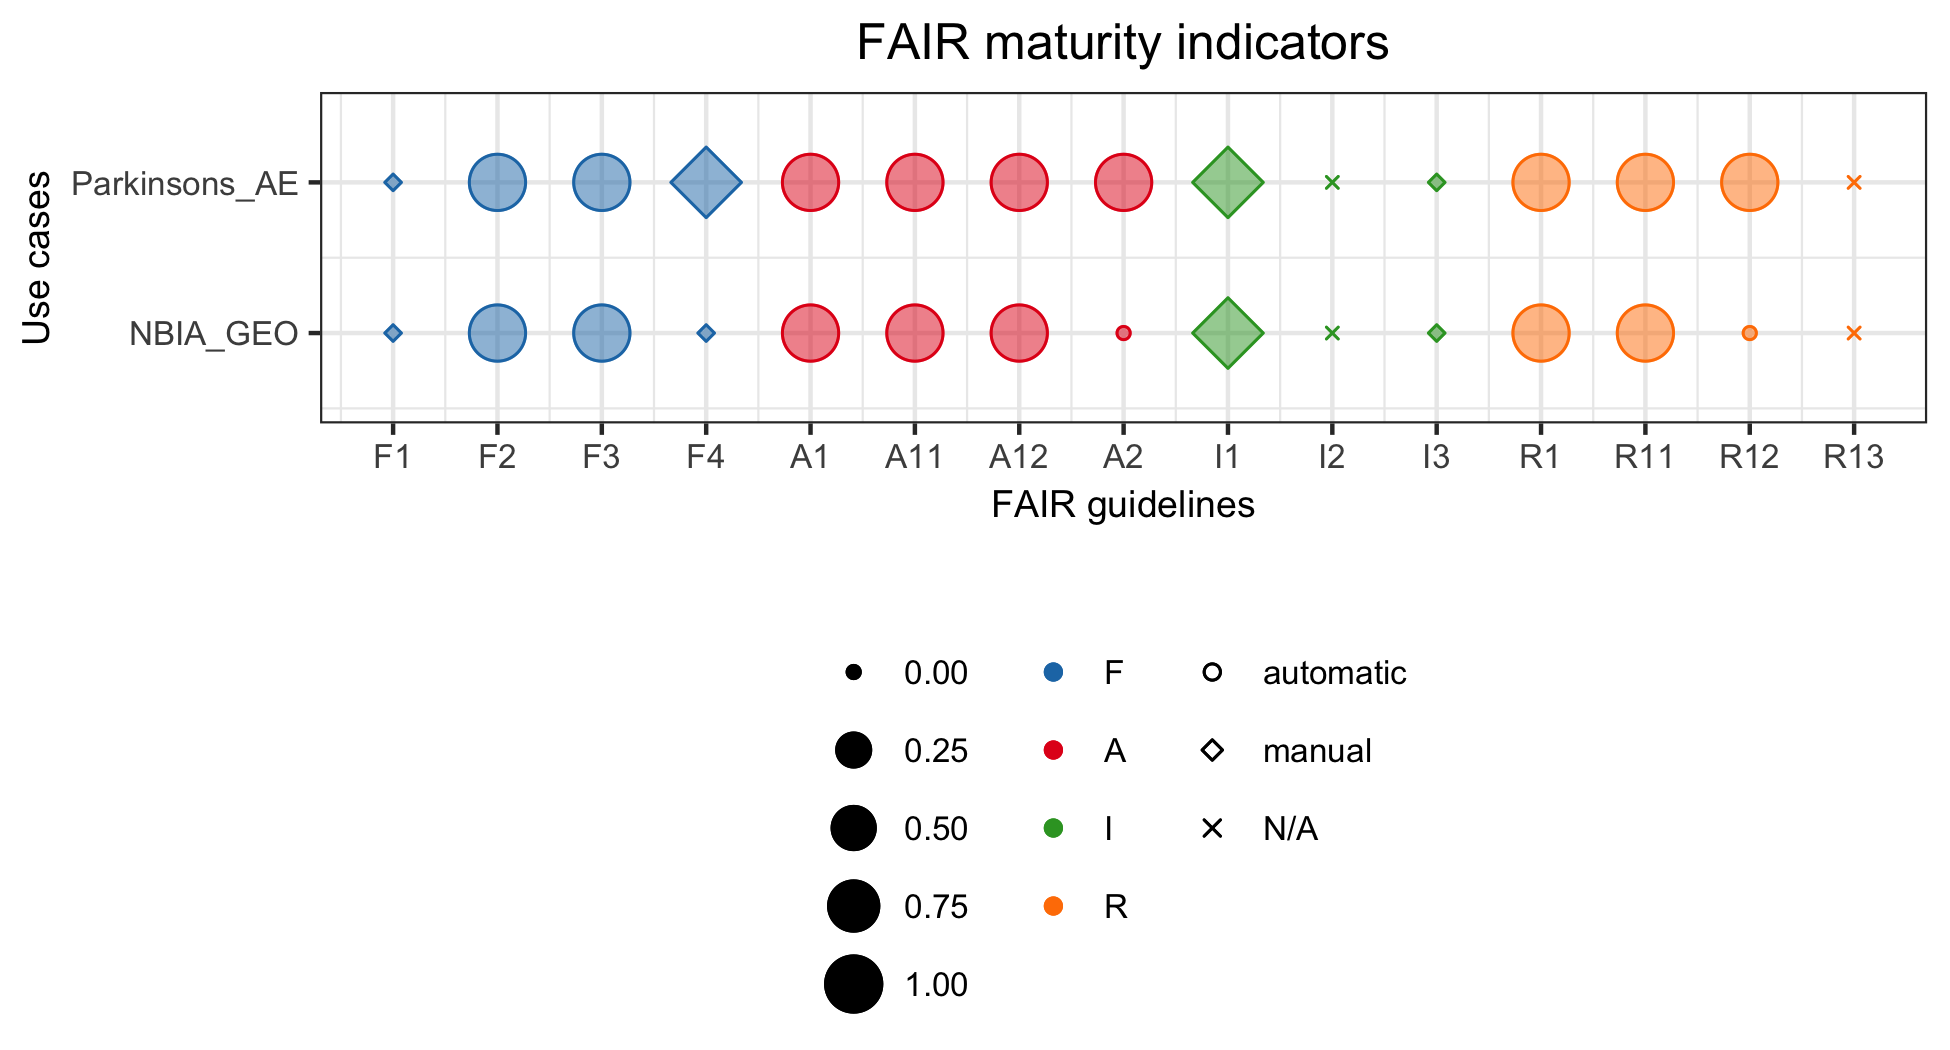

In [40]:
%%R -i df -w 6.5 -h 3.5 --units in -r 300 #-i df 

library(ggplot2)

# variables
y_values   <- seq(1, nrow(df))
y_values   <- sort(y_values, decreasing = TRUE)
n_of_cases <- ncol(df)-3
#n_of_cases <- 4
case_names <- rev(colnames(df)[1:n_of_cases])
# font size
title_text_size <- 12
axis_text_size  <- 9
tick_text_size  <- 8


# initiate graph
pl <- ggplot (data=df, aes(x=x_values1, y=y_values, color=principles, shape=retrieval_type))

# add cases in for loop
for (i in (1:n_of_cases)){

    # create a new dataframe with what needed for the current repository
    # (if one keeps indexes in geom_point, ggplot plots only the last very line - see https://stackoverflow.com/questions/18444620/set-layers-in-ggplot2-via-loop)
    gg.data <- data.frame(current_df=df[i], x_values=rep(i, nrow(df)), principles=df$principles, retrieval_type=df$retrieval_type)
   
    # change specific column name (e.g.DANSEASY) to a generic name
    colnames(gg.data)[1]<-"dataset"
    
    pl <- pl + 
          geom_point(data=gg.data, aes(x=x_values, y=y_values, size=dataset, color=principles, shape=retrieval_type)) + # add size, color, and shape
          geom_point(data=gg.data, aes(x=x_values, y=y_values, size=dataset, fill=principles, shape=retrieval_type), alpha=0.5, show.legend = FALSE) # add fill but do not show the legend (it would be the same as for color)
}

# add layers to plot
pl <- pl +
        # change shapes to squares, circles, and crosses
        scale_shape_manual(values = c(21,23,4)) +
        # background
        theme_bw() +  
        # flip x and y
        coord_flip()  +
        # axis ticks
        scale_x_reverse(limits=c(2.5,0.5), breaks=seq(n_of_cases,1,-1),  labels=c(colnames(df)[n_of_cases:1])) +  
        scale_y_reverse(limits=c(15, 1),   breaks=seq(15,1,-1), labels=df$metric_names) + 
        theme(axis.text.x = element_text(size = tick_text_size)) + 
        theme(axis.text.y = element_text(size = tick_text_size)) +
        # axis text
        xlab ("Use cases") +
        ylab ("FAIR guidelines") +
        theme(text = element_text( size = axis_text_size)) + 
        # change colors for lines
        scale_color_manual(values=c("#e31a1c", "#1f78b4", "#33a02c", "#ff7f00") ,
                           labels = c("F", "A", "I", "R"),
                           breaks = c("F", "A", "I", "R")
                          ) +  
        # change colors for fills
        scale_fill_manual(values=c("#e31a1c", "#1f78b4", "#33a02c", "#ff7f00")) +
        # title
        ggtitle("FAIR maturity indicators") +
        theme(plot.title = element_text(size = title_text_size, hjust = 0.5))  +
        # legend - colors
        theme(legend.text = element_text(size=tick_text_size), legend.key.size = unit(0.2, "cm")) + 
        labs(color="") +                             # no legend title   
        labs(size="")  +                             # no legend title 
        labs(shape="") +                             # no legend title 
        theme (legend.spacing.x = unit(0.1, "cm"),   # reduce horizontal space between legends
               legend.box = "horizontal",            # put legends next to each other
               legend.direction = "vertical",        # 
               legend.position = "bottom",           # under the graph
               legend.key.size = unit(1.3, 'lines'), # space better legend items
               legend.margin=margin(c(1,7,1,1))) +   # margin around each legend 
        guides(color = guide_legend(order=2),        # change legend order
               size  = guide_legend(order=1),
               shape = guide_legend(order=3))
        

# display
pl

In [41]:
%%R 
# requires the package "svglite" to save as svg
#ggsave("outcome_comparison.svg", plot = last_plot(), width=6.5, height=3.5, dpi=300) # comment if used in mybinder, uncomment if used locally 

---


<a name="dependencies"></a>
## Dependencies 

In [42]:
%reload_ext watermark
%watermark -v -m -p bs4,os,pandas,requests,xml.etree.ElementTree,io
print ("")
%watermark -u -n -t -z

CPython 3.7.3
IPython 7.4.0

bs4 4.7.1
os unknown
pandas 0.24.2
requests 2.21.0
xml.etree.ElementTree unknown
io unknown

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit

last updated: Sun Aug 11 2019 09:50:14 CEST


In [43]:
%%R
sessionInfo()

R version 3.3.3 (2017-03-06)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS  10.13.6

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] gdtools_0.1.9 ggplot2_3.1.0

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.1       svglite_1.2.2    digest_0.6.18    withr_2.1.2     
 [5] crayon_1.3.4     dplyr_0.8.1      assertthat_0.2.1 grid_3.3.3      
 [9] plyr_1.8.4       R6_2.4.0         gtable_0.2.0     magrittr_1.5    
[13] scales_1.0.0     pillar_1.4.0     rlang_0.3.4      lazyeval_0.2.1  
[17] labeling_0.3     glue_1.3.1       purrr_0.3.2      munsell_0.5.0   
[21] pkgconfig_2.0.2  colorspace_1.3-2 tidyselect_0.2.5 tibble_2.1.1    


In [44]:
%watermark -u -n -t -z

last updated: Sun Aug 11 2019 09:50:14 CEST


---

<a name="supplementary_information"></a>
## Supplementary information     

#### Metadata of the dataset in xml:

In [45]:
for case_id in range (0, 2):

    print ("--> " + repository_name[case_id] + " :")
    pretty_print_xml(metadata_xml[case_id])
    print (" ")
    print ("---------------------------------------------------------------")

--> ArrayExpress :
<id>
   219251
<accession>
   E-MTAB-1194
<name>
   Transcription profiling by array of human frontal cortex (area 8) from Parkinson disease cases and controls
<releasedate>
   2013-06-02
<lastupdatedate>
   2012-07-02
<organism>
   Homo sapiens
<experimenttype>
   transcription profiling by array
<experimentdesign>
   co-expression
<experimentdesign>
   disease state
<id>
   None
<id>
<text>
   Microarrays of frontal cortex (area 8) of Parkinson cases and controls
<text>
<contact>
   Agatha Schluter
<contact>
<role>
   submitter
<role>
<email>
   aschluter@idibell.org
<email>
<accession>
   23656994
<accession>
<authors>
   Garcia-Esparcia P, Schlüter A, Carmona M, Moreno J, Ansoleaga B, Torrejón-Escribano B, Gustincich S, Pujol A, Ferrer I.
<authors>
<title>
   Functional Genomics Reveals Dysregulation of Cortical Olfactory Receptors in Parkinson Disease: Novel Putative Chemoreceptors in the Human Brain.
<title>
<publication>
   Journal of Neuropathology & Experime

#### Metadata of the dataset in lists (no nesting):

In [46]:
for case_id in range (0, 2):

    print ("--> " + repository_name[case_id] + " :")
    
    for a in range(0,len(metadata_list[case_id][0])):
        print (metadata_list[case_id][0][a] + ": " + metadata_list[case_id][1][a])
    print (" ")
    print ("---------------------------------------------------------------")


--> ArrayExpress :
id: 219251
accession: e-mtab-1194
name: transcription profiling by array of human frontal cortex (area 8) from parkinson disease cases and controls
releasedate: 2013-06-02
lastupdatedate: 2012-07-02
organism: homo sapiens
experimenttype: transcription profiling by array
experimentdesign: co-expression
experimentdesign: disease state
id: none
text: microarrays of frontal cortex (area 8) of parkinson cases and controls
contact: agatha schluter
role: submitter
email: aschluter@idibell.org
accession: 23656994
authors: garcia-esparcia p, schlüter a, carmona m, moreno j, ansoleaga b, torrejón-escribano b, gustincich s, pujol a, ferrer i.
title: functional genomics reveals dysregulation of cortical olfactory receptors in parkinson disease: novel putative chemoreceptors in the human brain.
publication: journal of neuropathology & experimental neurology
year: 2013
category: age
value: 49 year
value: 52 year
value: 54 year
value: 57 year
value: 58 year
value: 66 year
value: 70

#### Metadata of the repositories in xml (no nesting):

In [47]:
for case_id in range (0, 2):

    print ("--> " + repository_name[case_id] + " :")
    pretty_print_xml(re3data_repo_root[case_id])
    print (" ")
    print ("---------------------------------------------------------------")


--> ArrayExpress :
<{http://www.re3data.org/schema/2-2}re3data.orgIdentifier>
   r3d100010222
<{http://www.re3data.org/schema/2-2}re3data.orgIdentifier>
<{http://www.re3data.org/schema/2-2}repositoryName>
   ArrayExpress
<{http://www.re3data.org/schema/2-2}repositoryName>
<{http://www.re3data.org/schema/2-2}additionalName>
   functional genomics data
<{http://www.re3data.org/schema/2-2}additionalName>
<{http://www.re3data.org/schema/2-2}repositoryURL>
   https://www.ebi.ac.uk/arrayexpress/
<{http://www.re3data.org/schema/2-2}repositoryURL>
<{http://www.re3data.org/schema/2-2}repositoryIdentifier>
   RRID:nif-0000-30123
<{http://www.re3data.org/schema/2-2}repositoryIdentifier>
<{http://www.re3data.org/schema/2-2}repositoryIdentifier>
   RRID:SCR_002964
<{http://www.re3data.org/schema/2-2}repositoryIdentifier>
<{http://www.re3data.org/schema/2-2}repositoryIdentifier>
   FAIRsharing_doi:10.25504/FAIRsharing.6k0kwd
<{http://www.re3data.org/schema/2-2}repositoryIdentifier>
<{http://www.re3d

#### Metadata of the repositories in lists (no nesting):

In [48]:
for case_id in range (0, len(repository_name)):

    print ("--> " + repository_name[case_id] + " :")
    
    
    for a in range(0,len(re3data_metadata_list[case_id][0])):
        print (re3data_metadata_list[case_id][0][a] + ": " + re3data_metadata_list[case_id][1][a])
    print (" ")
    print ("---------------------------------------------------------------")

--> ArrayExpress :
{http://www.re3data.org/schema/2-2}re3data.orgidentifier: r3d100010222
{http://www.re3data.org/schema/2-2}repositoryname: arrayexpress
{http://www.re3data.org/schema/2-2}additionalname: functional genomics data
{http://www.re3data.org/schema/2-2}repositoryurl: https://www.ebi.ac.uk/arrayexpress/
{http://www.re3data.org/schema/2-2}repositoryidentifier: rrid:nif-0000-30123
{http://www.re3data.org/schema/2-2}repositoryidentifier: rrid:scr_002964
{http://www.re3data.org/schema/2-2}repositoryidentifier: fairsharing_doi:10.25504/fairsharing.6k0kwd
{http://www.re3data.org/schema/2-2}repositoryidentifier: omics_01023
{http://www.re3data.org/schema/2-2}description: arrayexpress is one of the major international repositories for high-throughput functional genomics data from both microarray and high-throughput sequencing studies, many of which are supported by peer-reviewed publications. data sets are either submitted directly to arrayexpress and curated by a team of specialist